![](../img/330-banner.png)

# Lecture 21: Communication

UBC 2022-23

Instructors: Mathias Lécuyer and Mehrdad Oveisi

## Announcements

- HW8 (last HW) due [Tomorrow April 10, 11:59pm](https://github.com/UBC-CS/cpsc330-2023W2?tab=readme-ov-file#deliverable-due-dates-tentative)
- Final exam
    - Wed, Apr 24, 2024 at 12:00 pm
    - Duration: 150 mins
    - Location: [See Exam schedule | Student Services (ubc.ca) (which is alphabetically split)](https://students.ubc.ca/enrolment/exams/exam-schedule)
    - [Piazza post](https://piazza.com/class/lr4y28ceun367s/post/641)
- Almost there, hang in there!

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os 
sys.path.append(os.path.join(os.path.abspath("../"), "code"))
from plotting_functions import *

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import log_loss
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

plt.rcParams["font.size"] = 12

## Learning objectives

- When communicating about applied ML, tailor an explanation to the intended audience.
- Apply best practices of technical communication, such as bottom-up explanations and reader-centric writing.
- Given an ML problem, analyze the decision being made and the objectives.
- Avoid the pitfall of thinking about ML as coding in isolation; build the habit of relating your work to the surrounding context and stakeholders.
- Interpret a confidence score or credence, e.g. what does it mean to be 5% confident that a statement is true.
- Maintain a healthy skepticism of `predict_proba` scores and their possible interpretation as credences.
- Be careful and precise when communicating confidence to stakeholders in an ML project.
- Identify misleading visualizations.

## ❓❓ Questions for you

**Select all of the following statements which are TRUE.**

- (A) Right censoring occurs when the endpoint of event has not been observed for all study subjects by the end of the study period.
- (B) Right censoring implies that the data is missing completely at random.
- (C) In the presence of right-censored data, binary classification models can be applied directly without any modifications or special considerations.
- (D) If we apply the `Ridge` regression model to predict tenure in right censored data, we are likely to underestimate it because the tenure observed in our data is shorter than what it would be in reality.
- (E) In survival analysis, unlike typical supervised machine learning problems, it is beneficial to make predictions on training examples where customers have not yet churned. 

## Recap

- What is right-censored data?
- What happens when we treat right-censored data the same as "regular" data?
    - Predicting churn vs. no churn
    - Predicting tenure
        - Throw away people who haven't churned
        - Assume everyone churns today
- Survival analysis encompasses predicting both churn and tenure and deals with censoring and can make rich and interesting predictions!
    - We can get survival curves which show the probability of survival over time.
    - KM model $\rightarrow$ doesn't look at features
    - CPH model $\rightarrow$ like linear regression, does look at the features and provides coefficients associated with each feature
    
<br><br><br><br>

## Attribution

- The first part of this lecture is adapted from [DSCI 542](https://github.com/UBC-MDS/DSCI_542_comm-arg), created by [David Laing](https://davidklaing.com/).
- The visualization component of this lecture benefited from discussions with  [DSCI 531](https://github.com/UBC-MDS/DSCI_531_viz-1) instructors.

## Motivation

### Why should we care about effective communication?

- Most ML practitioners work in an organization with >1 people.
- There will very likely be stakeholders other than yourself.
- Some of them might not have any background in ML or computer science. 
- If your ML model is going to automate some important decisions in the organization you need to be able to explain 
    - What does a particular result mean? 
    - When does the model work?
    - What are the risks? When does it fail?
    - Why the model made a certain prediction for a particular example?  
    - What are the consequences of using your model?
- If you are able to convince your manager that using is model is beneficial, then only there are chances of your work going in production. 
- That said, you want to be honest when discussing the aspects above. If you mis-communicate the performance of your model, people will find out when the deployed model does not quite give similar performance.  

### What are the problems with the following? 

![](../img/ml-communication.png)

- Does "accuracy" here refer to the accuracy in ML?
- Is there class imbalance?
- Are they reporting numbers on the training data or validation or test data?

### Main issues in ML-related communication 

- Overstating one's results / unable to articulate the limitations
- Unable to explain the predictions
- Can we trust test error?
- Why did a particular model (e.g., CatBoost) make that prediction?
- What does it mean if `predict_proba` outputs 0.9?

These issues are there because these things are actually very hard to explain!

<br><br>

## Activity: explaining `GridSearchCV`

Below are two possible explanations of `GridSearchCV` pitched to different audiences. Read them both and then follow the instructions at the end.

### Explanation 1

Machine learning algorithms, like an airplane's cockpit, typically involve a bunch of knobs and switches that need to be set.

![](https://i.pinimg.com/236x/ea/43/f3/ea43f3c7f3a8c92d884ce012c77628fd--cockpit-gauges.jpg)

For example, check out the documentation of the popular random forest algorithm [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Here's a list of the function arguments, along with their default values (from the documentation):

> class sklearn.ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

Holy cow, that's a lot of knobs and switches! As a machine learning practitioner, how am I supposed to choose `n_estimators`? Should I leave it at the default of 100? Or try 1000? What about `criterion` or `class_weight` for that matter? Should I trust the defaults?

Enter [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to save the day. The general strategy here is to choose the settings that perform best on the specific task of interest. So I can't say `n_estimators=100` is better than `n_estimators=1000` without knowing what problem I'm working on. For a specific problem, you usually have a numerical score that measures performance. `GridSearchCV` is part of the popular [scikit-learn](https://scikit-learn.org/) Python machine learning library. It works by searching over various settings and tells you which one worked best on your problem. 

The "grid" in "grid search" comes from the fact that tries all possible combinations on a grid. For example, if you want it to consider setting `n_estimators` to 100, 150 or 200, and you want it to consider setting `criterion` to `'gini'` or `'entropy'`, then it will search over all 6 possible combinations in a grid of 3 possible values by 2 possible values: 

|                    | `criterion='gini'` | `criterion='entropy'` |
|----------------------|--------|---------|
| `n_estimators=100` |    1     |    2     |
| `n_estimators=150` |    3     |    4     |
| `n_estimators=200` |    5     |    6     |

Here is a code sample that uses `GridSearchCV` to select from the 6 options we just mentioned. The problem being solved is classifying images of handwritten digits into the 10 digit categories (0-9). I chose this because the dataset is conveniently built in to scikit-learn:

In [2]:
# imports
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# load a dataset
data = datasets.load_digits()
X = data["data"]
y = data["target"]

# set up the grid search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=123),
    param_grid={"n_estimators": [100, 150, 200], "criterion": ["gini", "entropy"]},
)

# run the grid search
grid_search.fit(X, y)
grid_search.best_params_

{'criterion': 'gini', 'n_estimators': 100}

As we can see from the output above, the grid search selected `criterion='gini', n_estimators=100`, which was one of our 6 options above (specifically Option 1).

By the way, these "knobs" we've been setting are called [_hyperparameters_](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning) and the process of setting these hyperparameters automatically is called [_hyperparameter optimization_](https://en.wikipedia.org/wiki/Hyperparameter_optimization) or _hyperparameter tuning_.

~400 words, not including code.

<br><br><br><br><br><br>

### Explanation 2

https://medium.com/datadriveninvestor/an-introduction-to-grid-search-ff57adcc0998

Now unavailable, see the wayback machine's version:

https://web.archive.org/web/20220816003103/https://medium.datadriveninvestor.com/an-introduction-to-grid-search-ff57adcc0998?source=user_profile---------5----------------------------

~400 words, not including code.


<br><br><br><br><br><br>

### Discussion questions:

- What do you like about each explanation?
- What do you dislike about each explanation?
- What do you think is the intended audience for each explanation?
- Which explanation do you think is more effective overall for someone on Day 1 of CPSC 330?
- Each explanation has an image. Which one is more effective? What are the pros/cons?
- Each explanation has some sample code. Which one is more effective? What are the pros/cons?

After you're done reading, take ~5 min to consider the discussion questions above. Paste your answer to **at least one** of the above questions in the [Google Doc](https://docs.google.com/document/d/1KporRGtlFOuylfPTLip3E5_X-rOP0sWk7oUjMTwlxUA/edit?usp=sharing) under the appropriate question heading.

## Principles of good explanations

### Concepts *then* labels, not the other way around

The first explanation start with an analogy for the concept (and the label is left until the very end):

> Machine learning algorithms, like an airplane's cockpit, typically involve a bunch of knobs and switches that need to be set.

In the second explanation, the first sentence is wasted on anyone who doesn't already know what "hyperparameter tuning" means:

> Grid search is the process of performing hyper parameter tuning in order to determine the optimal values for a given model. 

The effectiveness of these different statements depend on your audience. 

See [this video](https://www.youtube.com/watch?v=px_4TxC2mXU): 
> I learned very early the difference between knowing the name of something and knowing something." - Richard Feynman.

### Bottom-up explanations

The [Curse of Knowledge](https://en.wikipedia.org/wiki/Curse_of_knowledge) leads to *top-down* explanations:

![](../img/top_down.png)

- When you know something well, you think about things in the context of all your knowledge. 
- Those lacking the context, or frame of mind, cannot easily understand. 

There is another way: *bottom-up* explanations:

![](../img/bottom_up.png)

When you're brand new to a concept, you benefit from analogies, concrete examples and familiar patterns.


In the previous examples, which one represented a bottom-up explanation and which one a top-down explanation?
<br><br><br><br>

### New ideas in small chunks

The first explanation has a hidden **conceptual skeleton**:

1. The concept of setting a bunch of values.
2. Random forest example.
3. The problem / pain point.
4. The solution.
5. How it works - high level.
6. How it works - written example.
7. How it works - code example.
8. The name of what we were discussing all this time.

### Reuse your running examples

Effective explanations often use the same example throughout the text and code. This helps readers follow the line of reasoning.

### Approach from all angles

When we're trying to draw mental boundaries around a concept, it's helpful to see **examples on all sides** of those boundaries. If we were writing a longer explanation, it might have been better to show more, e.g.

- Performance **with** and **without** hyperparameter tuning.
- **Other types** of hyperparameter tuning (e.g. `RandomizedSearchCV`).

### When experimenting, show the results asap

The first explanation shows the output of the code, whereas the second does not. This is easy to do and makes a big difference.

### Interesting to you != useful to the reader (aka it's not about you)

Here is something which was deleted from the first explanation:

> Some hyperparameters, like `n_estimators` are numeric. **Numeric** hyperparameters are like the **knobs** in the cockpit: you can tune them **continuously**. `n_estimators` is numeric. **Categorical** hyperparameters are like the **switches** in the cockpit: they can take on (two or more) **distinct values**. `criterion` is categorical.

It's a very **elegant analogy**! But is it **helpful?**

And furthermore, what is my hidden motivation for wanting to include it? Elegance, art, and the pursuit of higher beauty? Or _making myself look smart_? So maybe another name for this principle could be **It's not about you.**

<br><br><br><br>

## ML and decision-making

### ❓❓ Questions for you

Imagine you are tasked with developing a recommender system for YouTube. You possess data on which users clicked on which videos. After spending considerable time building a recommender system using this data, you realize it isn't producing high-quality recommendations. What could be the reasons for this?

<br><br><br><br>

Think beyond the data that's given to you. Questions you have to consider:

- Who is the decision maker?
- What are their objectives?
- What are their alternatives?
- What is their context?
- What data do I need?

- There is often a wide **gap** between **what people care about** and **what ML can do**.
- To understand what ML can do, let's think about what **decisions** will be made using ML. 


#### Decisions involve a few key pieces

- The **decision variable**: the variable that is manipulated through the decision.
  - E.g. how much should I sell my house for? (numeric)
  - E.g. should I sell my house? (categorical)
- The decision-maker's **objectives**: the variables that the **decision-maker ultimately cares about**, and wishes to manipulate indirectly through the decision variable.
  - E.g. my **total profit**, **time to sale**, etc.
- The **context**: the variables that mediate the relationship between the decision variable and the objectives.
  - E.g. the housing **market**, **cost** of marketing it, my **timeline**, etc.

## Break (5 min)

![](../img/eva-coffee.png)

<br><br>

## Confidence and `predict_proba`

- What does it mean to be "confident" in your results?
- When you perform analysis, you are **responsible for many judgment calls**.
- [Your results will be different than others'](https://fivethirtyeight.com/features/science-isnt-broken/#part1).
- As you make these judgments and start to form conclusions, how can you recognize your own uncertainties about the data so that you can communicate confidently?

### What does this mean for us, when we're trying to make claims about our data?

Let's **imagine** that the following claim is **true**:

> Vancouver has the highest cost of living of all cities in Canada.

Now let's consider a few **beliefs** we could hold:

1. Vancouver has the highest cost of living of all cities in Canada. **I am 95% sure of this.** 
2. Vancouver has the highest cost of living of all cities in Canada. **I am 55% sure of this.** 

The part is bold is called a [credence](https://en.wikipedia.org/wiki/Credence_(statistics)). Which belief is better?

But **what if it's actually Toronto** that has the highest cost of living in Canada?

1. Vancouver has the highest cost of living of all cities in Canada. **I am 95% sure of this.** 
2. Vancouver has the highest cost of living of all cities in Canada. **I am 55% sure of this.** 

Which belief is better now?

**Conclusion**: 
- We don't just want to be right.
- We want to be ***confident* when we're right** and ***hesitant* when we're wrong.**

### ❓❓ Questions for you

In our final exam, imagine if, along with your answers, we ask you to also provide a confidence score for each. This would involve rating how sure you are about each answer, perhaps on a percentage scale from 0% (completely unsure) to 100% (completely sure). This method not only assesses your knowledge but also your awareness of your own understanding, potentially impacting the grading process and highlighting areas for improvement. Who supports this idea 😉? 

<br><br><br><br><br><br><br><br>

### What does this have to do with applied ML?

- What if you `predict` that a credit card transaction is fraudulent?
  - We probably want `predict_proba` a lot of the time.
- What if `predict_proba` is 0.95 in that case?
  - How confident are YOU?
- What if you forecast that avocado prices will go up next week? 
  - How confident are you there?
- Or what if you predict a house price to be \\$800k? 
  - That is not even a true/false statement.

### Preferences in `LogisticRegression`

When you call `fit` for `LogisticRegression` it has similar **preferences**:

| | | | | | | |
|-|-|-|-|-|-|-|
|<span style="color:green;font-weight:bold;">correct and confident</span>| $>$ |<span style="color:blue;font-weight:bold;">correct and hesitant</span>| $>$ |<span style="color:orange;font-weight:bold;">incorrect and hesitant</span>| $>$ |<span style="color:red;font-weight:bold;">incorrect and confident</span>|

- There is a "loss" or "error" function like _mean squared error_, so lower values are better.
- When you call `fit`, it tries to minimize this metric.

### What should be the loss? (Activity: 4 mins)

- Consider the following made-up classification example where target (true `y`) is binary: -1 or 1. 
- The true $y$ (`y_true`) and models raw scores ($w^Tx_i$) are given to you. 
- You want to figure out how do you want to punish the mistakes made by the current model.
- How will you punish the model in each case?  

In [3]:
data = {
    "y_true": [1, 1, 1, 1, -1, -1, -1, -1],
    "raw score ($w^Tx_i$)": [10.0, 0.51, -0.1, -10, -12.0, -1.0, 0.4, 18.0],
    "correct? (yes/no)":["yes", "yes", "no", "no", "yes", "yes", "no", "no"],
    "confident/hesitant?":["confident", "hesitant", "hesitant", "confident", "confident", "hesitant", "hesitant", "confident"],
    "punishment":["None", "small punishment", "", "", "", "", "", ""]
}
pd.DataFrame(data)

,y_true,raw score ($w^Tx_i$),correct? (yes/no),confident/hesitant?,punishment
0,1,10.00,yes,confident,None
1,1,0.51,yes,hesitant,small punishment
2,1,-0.10,no,hesitant,
3,1,-10.00,no,confident,
4,-1,-12.00,yes,confident,
5,-1,-1.00,yes,hesitant,
6,-1,0.40,no,hesitant,
7,-1,18.00,no,confident,


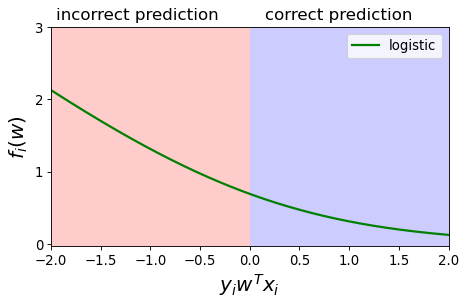

In [4]:
grid = np.linspace(-2, 2, 1000)
plot_loss_diagram()
plt.plot(grid, np.log(1 + np.exp(-grid)), color="green", linewidth=2, label="logistic")
plt.legend(loc="best", fontsize=12);

- When you are confident and correct, the loss is much smaller 
- When you are hesitant and correct, the loss is a bit higher
- If you are hesitant and incorrect the loss is even higher
- If you are confident and incorrect the loss is quite high. 
- Your loss goes to 0 as you approach 100% confidence in the correct answer.
- Your loss goes to infinity as you approach 100% confidence in the incorrect answer.
- The above picture shows loss for one example. 
- The real `LogisticRegression` takes summations of losses over all examples. 


Some nice examples: 
- (Optional) See also the very related [How to assign partial credit on an exam of true-false questions?](https://terrytao.wordpress.com/2016/06/01/how-to-assign-partial-credit-on-an-exam-of-true-false-questions/)
- [Scott Alexander](https://slatestarcodex.com/2019/01/22/2018-predictions-calibration-results/)
  - Look at how the plot starts at 50%. That is because being 40% confident of "X" is the same as being 60% confident of "not X".
- [Good Judgment Project](https://www.gjopen.com/)





<br><br><br><br>

## Visualizing your results

- Very powerful but at the same time can be misleading if not done properly. 

Pre-viewing review from [Calling BS visualization videos](https://www.youtube.com/watch?v=T-5aLbNeGo0&list=PLPnZfvKID1Sje5jWxt-4CSZD7bUI4gSPS&index=30&t=0s):

- Dataviz in the popular media.
  - e.g. [modern NYT](https://youtu.be/T-5aLbNeGo0?t=367)
- Misleading axes.
  - e.g. [vaccines](https://youtu.be/9pNWVMxaFuM?t=299)
- Manipulating bin sizes.
  - e.g. [tax dollars](https://youtu.be/zAg1wsYfwsM?t=196)
- Dataviz ducks.
  - e.g. [drinking water](https://youtu.be/rmii1hfP6d4?t=169)
  - "look how clever we are about design" -> making it about me instead of about you (see last class)
- Glass slippers.
  - e.g. [internet marketing tree](https://youtu.be/59teS0SUHtI?t=285)
- The principle of proportional ink.
  - e.g. [most read books](https://youtu.be/oNhusd3xFC4?t=147)

- [Demo of cleaning up a plot](https://www.darkhorseanalytics.com/blog/data-looks-better-naked)
- [Principle of proportional ink](https://serialmentor.com/dataviz/proportional-ink.html) from a viz textbook.

### Dataset

We'll be using [Kaggle House Prices dataset](https://www.kaggle.com/c/home-data-for-ml-course/), which we used in lecture 10. As usual, to run this notebook you'll need to download the data. For this dataset, train and test have already been separated. We'll be working with the train portion. 

In [5]:
df = pd.read_csv("../data/housing-kaggle/train.csv")
train_df, test_df = train_test_split(df, test_size=0.10, random_state=123)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
302,303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,205000
767,768,50,RL,75.0,12508,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,1300,7,2008,WD,Normal,160000
429,430,20,RL,130.0,11457,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Normal,175000
1139,1140,30,RL,98.0,8731,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,144000
558,559,60,RL,57.0,21872,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,175000


In [6]:
train_df.shape

(1314, 81)

### Let's separate `X` and `y`

In [7]:
X_train = train_df.drop(columns=["SalePrice"])
y_train = train_df["SalePrice"]

X_test = test_df.drop(columns=["SalePrice"])
y_test = test_df["SalePrice"]

### Feature types 

- We have mixed feature types and a bunch of missing values. 
- Now, let's identify feature types and transformations. 

In [8]:
drop_features = ["Id"]
numeric_features = [
    "BedroomAbvGr",
    "KitchenAbvGr",
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "YrSold",
]

In [9]:
ordinal_features_reg = [
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageQual",
    "GarageCond",
    "PoolQC",
]
ordering = [
    "Po",
    "Fa",
    "TA",
    "Gd",
    "Ex",
]  # if N/A it will just impute something, per below
ordering_ordinal_reg = [ordering] * len(ordinal_features_reg)
ordering_ordinal_reg

[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex']]

In [10]:
ordinal_features_oth = [
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "Functional",
    "Fence",
]
ordering_ordinal_oth = [
    ["NA", "No", "Mn", "Av", "Gd"],
    ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
    ["NA", "MnWw", "GdWo", "MnPrv", "GdPrv"],
]

The remaining features are categorical features.

In [11]:
categorical_features = list(
    set(X_train.columns)
    - set(numeric_features)
    - set(ordinal_features_reg)
    - set(ordinal_features_oth)
    - set(drop_features)
)
categorical_features

['Exterior2nd',
 'Exterior1st',
 'MiscFeature',
 'Condition1',
 'LandContour',
 'LotShape',
 'RoofMatl',
 'Electrical',
 'LotConfig',
 'GarageFinish',
 'RoofStyle',
 'Utilities',
 'MSZoning',
 'Alley',
 'MasVnrType',
 'Street',
 'BldgType',
 'Foundation',
 'PavedDrive',
 'MoSold',
 'SaleType',
 'HouseStyle',
 'Heating',
 'MSSubClass',
 'Condition2',
 'Neighborhood',
 'LandSlope',
 'CentralAir',
 'GarageType',
 'SaleCondition']

### Applying feature transformations

- Since we have mixed feature types, let's use `ColumnTransformer` to apply different transformations on different features types.  

In [12]:
from sklearn.compose import ColumnTransformer, make_column_transformer

numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
ordinal_transformer_reg = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_reg),
)

ordinal_transformer_oth = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_oth),
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer_reg, ordinal_features_reg),
    (ordinal_transformer_oth, ordinal_features_oth),
    (categorical_transformer, categorical_features),
)

### Examining the preprocessed data

In [13]:
preprocessor.fit(X_train)
# Calling fit to examine all the transformers.

ColumnTransformer(transformers=[('drop', 'drop', ['Id']),
                                ('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['BedroomAbvGr', 'KitchenAbvGr', 'LotFrontage',
                                  'LotArea', 'OverallQual', 'OverallCond',
                                  'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                                  'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                                  'TotalBsmtSF', '...
                                 ['Exterior2nd', 'Exterior1st', 'MiscFeature',
                                  'Condition1', 'LandContour', 'LotShape',
                                  'RoofMatl', 'Electrical', 'LotConfig',
                                  'GarageFinish', 'RoofStyle', 'Utilities',
                                  'MSZoning', 'Alley', 'MasVnrType', 'Street',
                                  'BldgType', 'Foundation', 'PavedDrive',
                                  'MoSold', 'SaleType', 'HouseStyle', 'Heating',
                                  'MSSubClass', 'Condition2', 'Neighborhood',
                                  'LandSlope', 'CentralAir', 'GarageType',
                                  'SaleCondition'])])

In [14]:
ohe_columns = list(
    preprocessor.named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
)
new_columns = (
    numeric_features + ordinal_features_reg + ordinal_features_oth + ohe_columns
)

In [15]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train), index=X_train.index, columns=new_columns
)
X_train_enc.head()

,BedroomAbvGr,KitchenAbvGr,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_missing,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
302,0.154795,-0.222647,2.312501,0.381428,0.663680,-0.512408,0.993969,0.840492,0.269972,-0.961498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
767,1.372763,-0.222647,0.260890,0.248457,-0.054669,1.285467,-1.026793,0.016525,-0.573129,0.476092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
429,0.154795,-0.222647,2.885044,0.131607,-0.054669,-0.512408,0.563314,0.161931,-0.573129,1.227559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1139,0.154795,-0.222647,1.358264,-0.171468,-0.773017,-0.512408,-1.689338,-1.679877,-0.573129,0.443419,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
558,0.154795,-0.222647,-0.597924,1.289541,0.663680,-0.512408,0.828332,0.598149,-0.573129,0.354114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
X_test_enc = pd.DataFrame(
    preprocessor.transform(X_test), index=X_test.index, columns=new_columns
)
X_test_enc.head()

,BedroomAbvGr,KitchenAbvGr,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_missing,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
147,0.154795,-0.222647,-0.025381,-0.085415,0.663680,-0.512408,0.993969,0.792023,0.438592,-0.961498,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
676,1.372763,4.348569,-0.454788,-0.074853,-1.491366,-3.209221,-2.351883,-1.679877,-0.573129,-0.961498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1304,0.154795,-0.222647,-1.790721,-0.768279,0.663680,-0.512408,1.093350,0.937429,0.084490,-0.961498,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1372,0.154795,-0.222647,0.260890,-0.058176,0.663680,0.386530,0.894587,0.646617,-0.573129,1.162214,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1427,0.154795,-0.222647,-0.454788,0.073016,-0.773017,0.386530,-0.861157,-1.679877,-0.573129,0.301838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
X_train.shape, X_test.shape

((1314, 80), (146, 80))

### Training random forests and gradient boosted trees

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

Let's compare sklearn's `GradientBoostingRegressor` to `RandomForestRegressor` for different values of `n_estimators`.

In [19]:
n_estimators_values = [3, 10, 30, 100, 300]

In [20]:
score_rf_train = list()
score_rf_test = list()
score_gb_train = list()
score_gb_test = list()

for n_estimators in n_estimators_values:
    print(n_estimators)
    rf = TransformedTargetRegressor(
        RandomForestRegressor(n_estimators=n_estimators, random_state=123),
        func=np.log1p,
        inverse_func=np.expm1,
    )
    rf.fit(X_train_enc, y_train)
    score_rf_train.append(rf.score(X_train_enc, y_train))
    score_rf_test.append(rf.score(X_test_enc, y_test))

    gb = TransformedTargetRegressor(
        GradientBoostingRegressor(n_estimators=n_estimators, random_state=123),
        func=np.log1p,
        inverse_func=np.expm1,
    )
    gb.fit(X_train_enc, y_train)
    score_gb_train.append(gb.score(X_train_enc, y_train))
    score_gb_test.append(gb.score(X_test_enc, y_test))

3
10
30
100
300


### Confusing and perhaps misleading visualization of results

Here is a low-quality plot that is confusing and perhaps downright misleading:

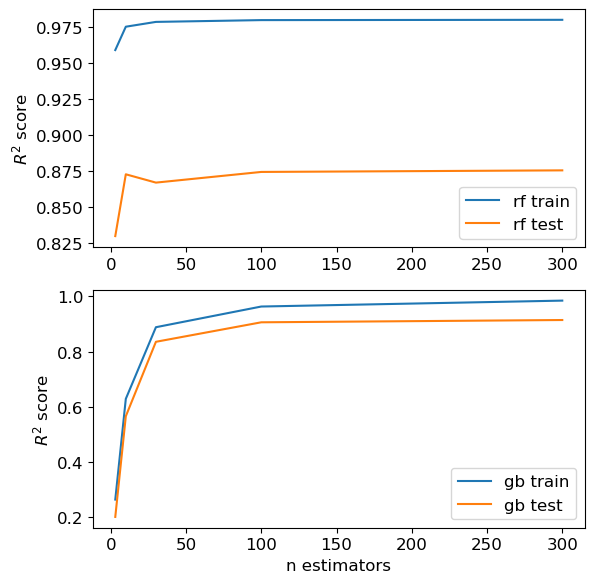

In [21]:
plt.figure(figsize=(6,6));
plt.subplot(2, 1, 1)
plt.plot(n_estimators_values, score_rf_train, label="rf train")
plt.plot(n_estimators_values, score_rf_test, label="rf test")
plt.ylabel("$R^2$ score")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(n_estimators_values, score_gb_train, label="gb train")
plt.plot(n_estimators_values, score_gb_test, label="gb test")
plt.xlabel("n estimators")
plt.ylabel("$R^2$ score")
plt.legend()
plt.tight_layout();

#### Why is this confusing/misleading? 

Consider the following plot instead:

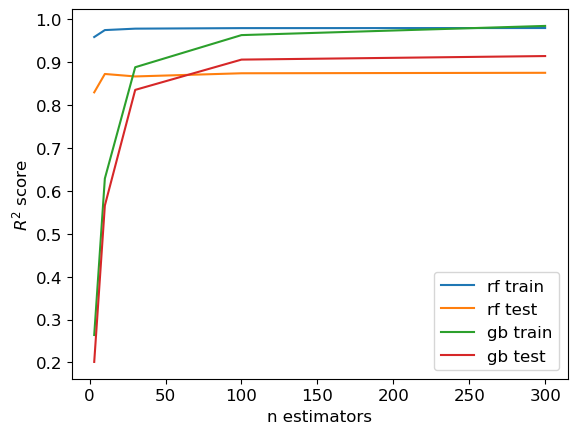

In [22]:
plt.plot(n_estimators_values, score_rf_train, label="rf train")
plt.plot(n_estimators_values, score_rf_test, label="rf test")

plt.plot(n_estimators_values, score_gb_train, label="gb train")
plt.plot(n_estimators_values, score_gb_test, label="gb test")
plt.xlabel("n estimators")
plt.ylabel("$R^2$ score")
plt.legend();

<br><br><br>

Could you create some visualizations such that it makes

- RF look better than GB
- GB look better than RF
- RF and GB look equally good


You can create your own misleading example and copy or screenshot it and paste it into the [Google Doc](https://docs.google.com/document/d/1KporRGtlFOuylfPTLip3E5_X-rOP0sWk7oUjMTwlxUA/edit?usp=sharing).

<br><br><br><br><br><br><br><br>

Here are some misleading plots. 

### RF better than GB

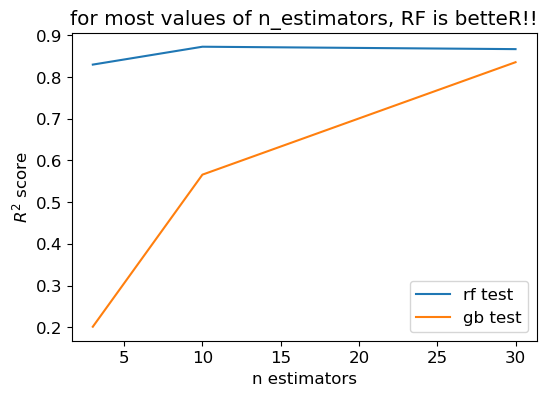

In [23]:
plt.figure(figsize=(6,4))
nmax = 3

# plt.plot(n_estimators_values[:nmax], score_rf_train[:nmax], label="rf train")
plt.plot(n_estimators_values[:nmax], score_rf_test[:nmax], label="rf test")
# plt.plot(n_estimators_values[:nmax], score_gb_train[:nmax], label="gb train")
plt.plot(n_estimators_values[:nmax], score_gb_test[:nmax], label="gb test")
plt.xlabel("n estimators")
plt.ylabel("$R^2$ score")
plt.legend()
plt.title("for most values of n_estimators, RF is betteR!!");

### GB better than RF

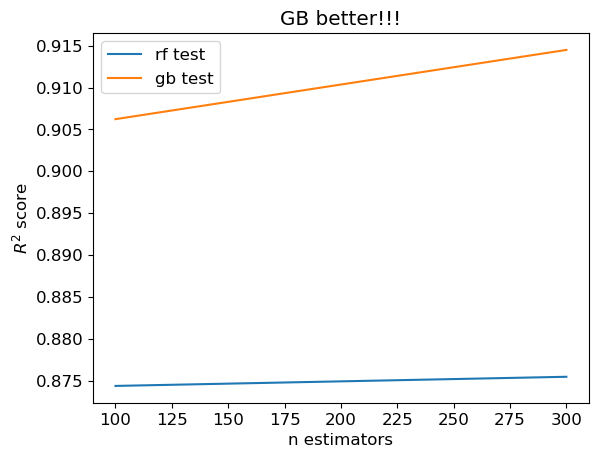

In [24]:
nmin = 3

# plt.plot(n_estimators_values, score_rf_test, label="rf test")
plt.plot(n_estimators_values[nmin:], score_rf_test[nmin:], label="rf test")

# plt.plot(n_estimators_values, score_gb_test, label="gb test")
plt.plot(n_estimators_values[nmin:], score_gb_test[nmin:], label="gb test")

plt.xlabel("n estimators")
plt.ylabel("$R^2$ score")
plt.legend()
plt.title("GB better!!!");

### Equally good

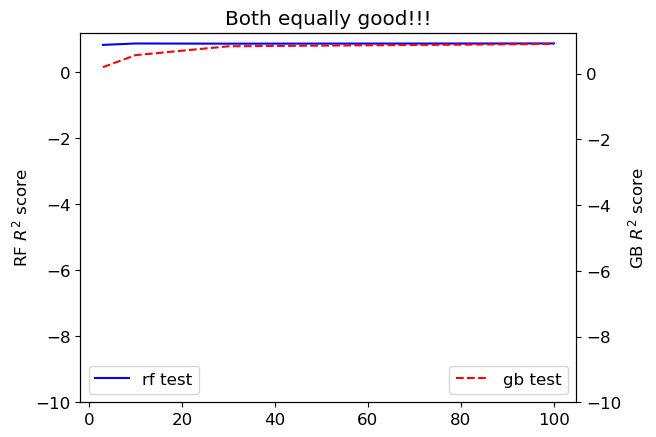

In [25]:
nmax = 4

# plt.plot(n_estimators_values, score_rf_train, label="rf train")
plt.plot(n_estimators_values[:nmax], score_rf_test[:nmax], "b", label="rf test")
plt.ylabel("RF $R^2$ score")
plt.ylim((-10, 1.2))
plt.legend(loc=0)
plt.twinx()
# plt.plot(n_estimators_values, score_gb_train, label="gb train")
plt.plot(n_estimators_values[:nmax], score_gb_test[:nmax], "--r", label="gb test")
plt.legend(loc=4)
plt.xlabel("n estimators")
plt.ylabel("GB $R^2$ score")
plt.ylim((-10, 1.25))
#plt.ylim((-0.01, 0.70))
plt.title("Both equally good!!!");

### Things to watch out for

- Chopping off the x-axis
    - the practice of starting the x-axis (or sometimes the y-axis) at a value other than zero to exaggerate the changes in the data   
- Saturate the axes
    - where the axes are set to ranges that are too narrow or too wide for the data being presented making it difficult to identify patterns
- Bar chart for a cherry-picked values
- Different y-axes

**Be critical of your visualizations and try to make them as honest as possible.**

<br><br>

## What did we learn today?

### Principles of effective communication
  - Concepts then labels, not the other way around
  - Bottom-up explanations
  - New ideas in small chunks
  - Reuse your running examples
  - Approaches from all angles  
  - When experimenting, show the results asap
  - **It's not about you.**

- Decision variables, objectives, and context.
- How does ML fit in?
- Expressing your confidence about the results
- Misleading visualizations.  

Have a great weekend! 

![](../img/eva-seeyou.png)